<a href="https://colab.research.google.com/github/NexPG/first_project_case/blob/main/2_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Выбор метрики

Основная: **Recall** (TP / (TP+FN)) — обоснование: бизнес важнее обнаружить уходящих клиентов (false negative — пропустил уходящего) даже ценой увеличения false positives. Recall напрямую измеряет долю ушедших, которые были правильно предсказаны.

Вторичные:

**PR-AUC (Precision-Recall AUC)** — важен при несбалансированных классах; подчёркивает точность для positive-класса.

**ROC-AUC** — полезен, но менее информативен при сильной дисбалансировке (игнорирует порог). Хорош как общее качество модели, но не заменяет Recall/PR-AUC.

**F1-score, Precision** — отчитываемся для баланса между Recall и Precision.

Протокол отчётности: главная метрика — Recall (максимизируем); при этом отслеживаем PR-AUC и Precision чтобы не сделать модель «кричащей» ***(высокий Recall + очень низкая Precision — много ложных тревог).***

In [ ]:
# Исправленный пайплайн для предсказания оттока клиентов
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import make_scorer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# 1. Загрузка
data = pd.read_csv('train.csv')

# 2. Быстрая подготовка колонок
drop_cols = ['CustomerId', 'Surname', 'id']
for c in drop_cols:
    if c in data.columns:
        data = data.drop(columns=c)

target = 'Exited'
# numeric candidates
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# categorical
cat_cols = ['Geography', 'Gender']  # HasCrCard, IsActiveMember уже бинар 0/1

# 3. Преобразования для числовых и категориальных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # трансформация баланса при желании: ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='passthrough')  # passthrough оставит HasCrCard, IsActiveMember если они есть

# 4. Модель: логистическая регрессия с class_weight (baseline)
clf = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)

# 5. Полный пайплайн (без SMOTE). Это безопасный baseline.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', clf)
])

# 6. Train-test split (hold-out) -- stratify чтобы сохранить баланс классов
X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 7. Cross-Validation: StratifiedKFold и scoring по Recall (primary)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}

cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

# 8. Результаты CV (средние)
for metric in scoring.keys():
    scores = cv_results['test_' + metric]
    print(f"CV {metric}: mean={np.mean(scores):.4f}, std={np.std(scores):.4f}")

# 9. Обучаем на всем train и финальная оценка на hold-out
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("\nHold-out results:")
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC (average precision):", average_precision_score(y_test, y_proba))


# 10. Альтернатива: использование SMOTE в пайплайне (применяется только к тренировочным данным внутри CV)
# Если хотите попробовать SMOTE, используйте imblearn Pipeline:
smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
])

# Cross-validate with smote (пример)
cv_results_smote = cross_validate(smote_pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
print("\n--- With SMOTE CV results ---")
for metric in scoring.keys():
    scores = cv_results_smote['test_' + metric]
    print(f"SMOTE CV {metric}: mean={np.mean(scores):.4f}, std={np.std(scores):.4f}")

# Окончательное замечание: сравнить recall/precision между baseline (class_weight) и SMOTE,
# выберать вариант, где recall вырос, но precision не стал неприемлемо малым.

CV recall: mean=0.7373, std=0.0021
CV precision: mean=0.4499, std=0.0025
CV f1: mean=0.5588, std=0.0022
CV roc_auc: mean=0.8194, std=0.0015
CV pr_auc: mean=0.5823, std=0.0041

Hold-out results:
Recall: 0.7342497136311569
Precision: 0.45041721563460696
F1: 0.5583319723447112
ROC-AUC: 0.8159138697422436
PR-AUC (average precision): 0.568873092564272

--- With SMOTE CV results ---
SMOTE CV recall: mean=0.7362, std=0.0029
SMOTE CV precision: mean=0.4521, std=0.0028
SMOTE CV f1: mean=0.5602, std=0.0023
SMOTE CV roc_auc: mean=0.8195, std=0.0015
SMOTE CV pr_auc: mean=0.5831, std=0.0041



Optimal thresholds by recall requirement:
Recall_target | Threshold | Precision | Recall
0.75          | 0.480     | 0.435     | 0.750
0.8           | 0.419     | 0.393     | 0.800
0.85          | 0.355     | 0.354     | 0.850


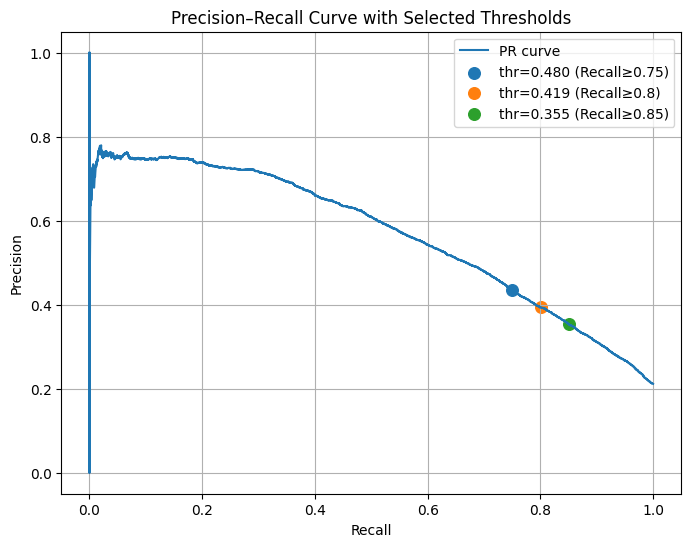

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, f1_score

# Предполагается, что уже обучен пайплайн:
# pipeline.fit(X_train, y_train)

y_proba = pipeline.predict_proba(X_test)[:, 1]   # вероятности класса 1
y_pred_default = (y_proba >= 0.5).astype(int)

# 1. Строим precision-recall curves
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

# thresholds на 1 меньше, чем prec/rec → выровняем для удобства
thresholds_full = np.append(thresholds, 1.0)

# ---- Функция выбора лучшего порога ----
def best_threshold_for_recall(target_recall):
    """Возвращает лучший порог, обеспечивающий Recall >= target_recall,
       максимизируя Precision (или F1)."""
    mask = rec >= target_recall
    if mask.sum() == 0:
        return None, None, None

    # Выбираем индекс с максимальной precision
    idx = np.argmax(prec[mask])

    # преобразуем обратно индекс в глобальный
    global_idx = np.arange(len(rec))[mask][idx]

    best_thr = thresholds_full[global_idx]
    best_prec = prec[global_idx]
    best_rec = rec[global_idx]
    return best_thr, best_prec, best_rec


targets = [0.75, 0.80, 0.85]

results = {}
for t in targets:
    thr, p, r = best_threshold_for_recall(t)
    results[t] = (thr, p, r)

# ---- Печатаем таблицу ----
print("\nOptimal thresholds by recall requirement:")
print("Recall_target | Threshold | Precision | Recall")
for t in targets:
    thr, p, r = results[t]
    if thr is None:
        print(f"{t:<13} |  ---       |   ---     |   ---")
    else:
        print(f"{t:<13} | {thr:0.3f}     | {p:0.3f}     | {r:0.3f}")


# ---- Визуализация PR-curve ----
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, label='PR curve')

# отмечаем найденные точки
for t in targets:
    thr, p, r = results[t]
    if thr is not None:
        plt.scatter(r, p, s=70, label=f"thr={thr:.3f} (Recall≥{t})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve with Selected Thresholds")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, average_precision_score

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# ---------------------------
# 1. LOAD
# ---------------------------
data = pd.read_csv('train.csv')

drop_cols = ['CustomerId', 'Surname', 'id']
data = data.drop(columns=[c for c in drop_cols if c in data.columns])

target = 'Exited'

numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance',
                'NumOfProducts', 'EstimatedSalary']

cat_cols = ['Geography', 'Gender']


# ---------------------------
# 2. PREPROCESSING
# ---------------------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='passthrough')


# ---------------------------
# 3. DATA SPLIT
# ---------------------------
X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}


# ---------------------------
# 4. BASELINE: class_weight
# ---------------------------
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))
])

cv_base = cross_validate(baseline_pipeline, X_train, y_train, cv=cv,
                         scoring=scoring, n_jobs=-1)


# ---------------------------
# 5. SMOTE
# ---------------------------
smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
])

cv_smote = cross_validate(smote_pipeline, X_train, y_train, cv=cv,
                          scoring=scoring, n_jobs=-1)


# ---------------------------
# 6. Undersampling
# ---------------------------
under_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('under', RandomUnderSampler(random_state=42)),
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
])

cv_under = cross_validate(under_pipeline, X_train, y_train, cv=cv,
                          scoring=scoring, n_jobs=-1)


# ---------------------------
# 7. Таблица сравнения
# ---------------------------
def summarize(cv_res):
    return {
        'recall': np.mean(cv_res['test_recall']),
        'precision': np.mean(cv_res['test_precision']),
        'f1': np.mean(cv_res['test_f1']),
        'roc_auc': np.mean(cv_res['test_roc_auc']),
        'pr_auc': np.mean(cv_res['test_pr_auc'])
    }

results = pd.DataFrame({
    'Baseline_class_weight': summarize(cv_base),
    'SMOTE': summarize(cv_smote),
    'Undersampling': summarize(cv_under)
}).T

print("\n=== Сравнение методов (CV average) ===")
print(results.round(4))


=== Сравнение методов (CV average) ===
                       recall  precision      f1  roc_auc  pr_auc
Baseline_class_weight  0.7373     0.4499  0.5588   0.8194  0.5823
SMOTE                  0.7362     0.4521  0.5602   0.8195  0.5831
Undersampling          0.7375     0.4499  0.5589   0.8194  0.5824
